In [10]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
schema = {
    # --- strings ------------------------------------------------------------
    "location":      "string",
    "type":          "string",
    "block":         "string",
    "street":        "string",
    "storey_range":  "string",   
    "flat_model":     "string",

    # --- numerics -----------------------------------------------------------
    "area_sqm":      "float64",
    "price":         "float64", 
    "commence_date": "Int64",   
    "Quantity_Index":"Int64",
}

In [12]:
data = pd.read_csv("../data.csv", parse_dates=["date"], dtype=schema, usecols=range(11))
data.dtypes

date             datetime64[ns]
location         string[python]
type             string[python]
block            string[python]
street           string[python]
storey_range     string[python]
area_sqm                float64
flat_model       string[python]
commence_date             Int64
Quality_Index             int64
price                   float64
dtype: object

In [25]:
data.dropna(inplace=True)

data["year"]  = data["date"].dt.year
data["month"] = data["date"].dt.month

y = data["price"]
X = data.drop(columns=["price", "date"])   

num_fix = ["commence_date", "Quality_Index"]
X[num_fix] = X[num_fix].astype("float64")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

cat_cols = X.select_dtypes(include=["string", "object"]).columns.tolist()
cat_idx  = [X.columns.get_loc(c) for c in cat_cols]

train_pool = Pool(X_train, y_train, cat_features=cat_idx)
test_pool  = Pool(X_test , y_test , cat_features=cat_idx)

model = CatBoostRegressor(
    loss_function="RMSE",
    iterations=10_000,     
    depth=10,
    learning_rate=0.03,
    l2_leaf_reg=2,
    random_seed=42,
    verbose=500,           
)

model.fit(train_pool)

y_train_pred = model.predict(train_pool)
y_test_pred  = model.predict(test_pool)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse  = mean_squared_error(y_test , y_test_pred)

print(f"\nTrain MSE : {train_mse:,.2f}")
print(f"Test  MSE : {test_mse:,.2f}")

0:	learn: 109563.0449091	total: 142ms	remaining: 23m 39s
500:	learn: 19719.8294414	total: 17.2s	remaining: 5m 26s
1000:	learn: 16978.1605839	total: 35.1s	remaining: 5m 15s
1500:	learn: 15780.4227327	total: 54.3s	remaining: 5m 7s
2000:	learn: 14984.7129379	total: 1m 13s	remaining: 4m 52s
2500:	learn: 14375.4501014	total: 1m 33s	remaining: 4m 39s
3000:	learn: 13856.4853162	total: 1m 53s	remaining: 4m 23s
3500:	learn: 13402.6277360	total: 2m 13s	remaining: 4m 8s
4000:	learn: 12982.9348923	total: 2m 34s	remaining: 3m 51s
4500:	learn: 12594.5716530	total: 2m 55s	remaining: 3m 34s
5000:	learn: 12230.5743048	total: 3m 16s	remaining: 3m 16s
5500:	learn: 11870.9938949	total: 3m 38s	remaining: 2m 58s
6000:	learn: 11537.8585146	total: 4m	remaining: 2m 40s
6500:	learn: 11226.8604588	total: 4m 22s	remaining: 2m 21s
7000:	learn: 10917.9102352	total: 4m 44s	remaining: 2m 1s
7500:	learn: 10645.5479424	total: 5m 6s	remaining: 1m 42s
8000:	learn: 10381.1583054	total: 5m 28s	remaining: 1m 22s
8500:	learn

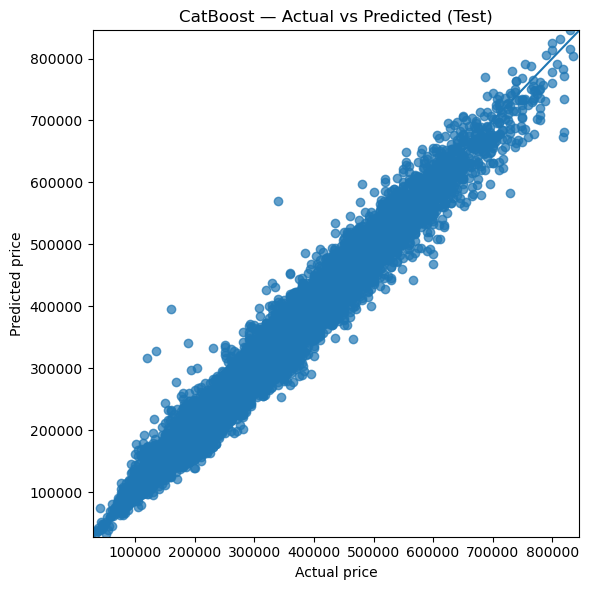

In [26]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)

lims = [min(y_test.min(), y_test_pred.min()),
        max(y_test.max(), y_test_pred.max())]
plt.plot(lims, lims)  
plt.xlim(lims)
plt.ylim(lims)

plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("CatBoost — Actual vs Predicted (Test)")
plt.tight_layout()
plt.show()

In [27]:
y_test.shape

(42793,)